# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
import pandas as pd
import numpy as np
import os

DATA_FOLDER = 'data/' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [2]:
# Write your answer here
countries = dict.fromkeys(['guinea', 'liberia', 'sl'])

for country in countries:
    FULL_PATH = DATA_FOLDER + "ebola/" + country + "_data/"
    print("")
    for csv_file in os.listdir(FULL_PATH):
        if countries[country] is None:
            countries[country] = pd.read_csv(FULL_PATH + csv_file, sep=',')
            print(countries[country].shape[1], end=",")
        else:
            nextFrame = pd.read_csv(FULL_PATH + csv_file, sep=',')
            print(nextFrame.shape[1], end=",")
            countries[country] = pd.concat([countries[country], nextFrame], axis=0)

            
            


24,24,24,24,24,24,24,24,24,24,24,24,16,24,24,24,24,24,24,21,24,24,
18,18,18,18,16,18,16,16,13,18,18,16,18,18,18,18,14,17,18,16,17,18,18,14,18,19,15,18,15,13,18,14,18,17,16,14,18,18,14,15,18,18,18,14,16,14,18,18,18,18,17,18,18,18,18,14,14,18,14,18,14,14,14,18,18,18,18,18,17,17,15,18,18,16,18,18,18,18,14,18,18,18,14,18,18,16,18,17,14,14,18,18,17,14,18,18,18,18,18,14,
19,17,17,17,18,20,17,17,20,17,17,17,17,18,18,17,17,17,17,17,21,18,17,20,21,17,18,17,17,17,17,17,17,18,17,21,17,17,17,20,21,18,18,17,17,21,17,18,18,17,18,18,17,19,17,18,20,20,17,18,17,17,19,18,18,17,17,17,17,17,17,17,17,17,18,17,20,17,21,17,17,17,18,17,17,21,18,17,20,21,21,17,18,18,20,17,17,18,17,18,18,17,17,

We only consider confirmed cases as legitimate cases.

In [38]:
dt_info = {
    'guinea' : {
        'case' : 'New cases of confirmed',
        'deaths' : [
            'New deaths registered',
            'New deaths registered today'
        ],
        'var' : 'Description',
        'exclude' : ['Totals', 'Description'],
        'date' : 'Date',
        'dateformat' : '%Y-%m-%d'
    },
    'liberia' : {
        'case' : 'New case/s (confirmed)',
        'deaths' : [
            'Newly reported deaths'
        ],
        'var' : 'Variable',
        'exclude' : ['National', 'Variable'],
        'date' : 'Date',
        'dateformat' : '%m/%d/%Y'
    },
    'sl' : {
        'case' : 'new_confirmed',
        'deaths' : [
            'etc_new_deaths'
        ],
        'var' : 'variable',
        'exclude' : ['National', 'variable'],
        'date' : 'date',
        'dateformat' : '%Y-%m-%d'
    }
}
"""
 TODO:
    - investigate unnamed
    - check that variable columns in original data does not cause trouble
    - 
"""

cases = []
deaths = []
for country in countries:
    info = dt_info[country]
    df = countries[country]

    # filter out cases and deaths

    # parse date
    df[info['date']] = pd.to_datetime(df[info['date']])
    # set index
    df = df.set_index(info['date'])

    # sort by date
    df.sort_index(inplace=True)

    # get rid of NaN values
    df = df.fillna(0)
    # get rid of dashes
    df = df.replace('-', '')

    
    # filter out cases
    dfc = df.loc[df[info['var']] == info['case']].copy(deep=True)
    # filter out deaths
    dfd = df.loc[df[info['var']].isin(info['deaths'])].copy(deep=True)
    
    # delete non-numerics
    for column in info['exclude']:
        del dfc[column]
        del dfd[column]
        
    # convert all values to numeric
    for column in list(dfc):
        dfc[column] = pd.to_numeric(dfc[column])
        dfd[column] = pd.to_numeric(dfd[column])
        
    # collapse regions
    dfc[country] = dfc[list(dfc)].sum(axis=1)
    dfc = dfc[country]
    dfd[country] = dfd[list(dfd)].sum(axis=1)
    dfd = dfd[country]
    
    # exclude 4th to 9th december in liberia (wrong data, total instead of new cases)
    if country == 'liberia':
        dfc.loc['2014-12-04':'2014-12-09'] = 0
    # create daily average per month
    dfc = dfc.groupby(pd.TimeGrouper(freq='M')).mean()
    cases.append(dfc)
    dfd = dfd.groupby(pd.TimeGrouper(freq='M')).mean()
    deaths.append(dfd)
    

#header_c = pd.MultiIndex.from_product(
#    [list(countries), ['cases', 'deaths']
#)

dfc = pd.concat(cases, axis=1)
dfd = pd.concat(deaths, axis=1)
pd.concat([dfc, dfd], axis=1)

,guinea,liberia,sl,guinea,liberia,sl
Date,,,,,,
2014-06-30,NaN,2.142857,NaN,NaN,1.857143,NaN
2014-07-31,NaN,1.818182,NaN,NaN,4.272727,NaN
2014-08-31,12.4000,5.444444,19.600000,3.2000,23.222222,5.550000
2014-09-30,12.5625,6.166667,36.275862,3.5625,36.041667,4.344828
2014-10-31,6.0000,1.240000,57.535714,15.0000,28.120000,2.071429
2014-11-30,NaN,2.533333,63.238095,NaN,13.666667,0.428571
2014-12-31,NaN,1.111111,32.600000,NaN,0.000000,0.000000


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [ ]:
# Write your answer here

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [ ]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [ ]:
#read the data
titanic = pd.read_excel(DATA_FOLDER+'/titanic.xls')
titanic2 = titanic.copy()



We can see the types of the attribute using titanic.dtypes, while we use titanic.describe() to find the maximum and the minimum of the numerical attribute

In [12]:
titanic.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [13]:
titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


The following attributes can be categorical:
-pclass
-sex (can be trasformed in a dummy variable, too: 1 if the passeger was male, 0 instead)
-age can be trasformed in a categorical attribute: 1 value per decade
-embarked 



In [31]:
#trasforming sex to a categorical attribute
titanic['pclass'] = titanic.pclass.astype('category')

#trasforming sex to a categorical attribute
titanic['sex'] = titanic.sex.astype('category')

#trasforming embarked to a categorical attribute
titanic['embarked'] = titanic.embarked.astype('category')

#trasforming age to a categorical attribute
titanic.age = pd.cut(titanic.age, [0,10, 20,30,40,50,60,70,80], labels = [1,2,3,4,5,6,7,8])[:30]

titanic.dtypes


#sex can be trasformed to a dummy variable,too
#trasforming sex to a dummy attribute
#sex_map = {'male': 0, 'female': 1}
#titanic['sex'] = titanic.sex.map(sex_map)


0       S
1       S
2       S
3       S
4       S
5       S
6       S
7       S
8       S
9       C
10      C
11      C
12      C
13      S
14      S
15      S
16      C
17      C
18      C
19      C
20      S
21      S
22      C
23      C
24      S
25      C
26      C
27      C
28      S
29      S
       ..
1279    S
1280    S
1281    S
1282    S
1283    S
1284    S
1285    S
1286    C
1287    S
1288    S
1289    S
1290    S
1291    S
1292    S
1293    S
1294    S
1295    S
1296    S
1297    S
1298    S
1299    C
1300    C
1301    C
1302    C
1303    C
1304    C
1305    C
1306    C
1307    C
1308    S
Name: embarked, Length: 1309, dtype: category
Categories (3, object): [C, Q, S]

We suppose that most part of the passengers will be placed in 3rd class, that there are more male than female passengers and that the most part will be between 30 and 40 years old. By plotting the data, we see that all our assumptions were correct, but the one regarding attribute age, in fact there are more passengers between 20 and 30 years

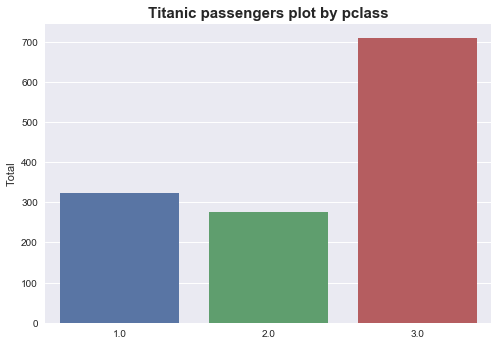

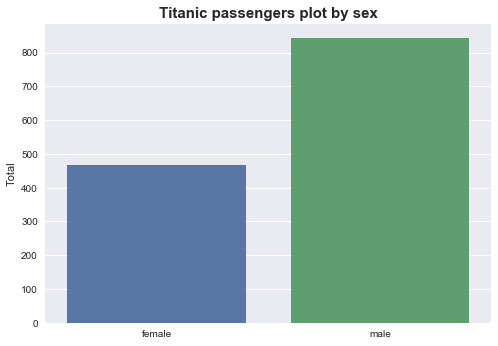

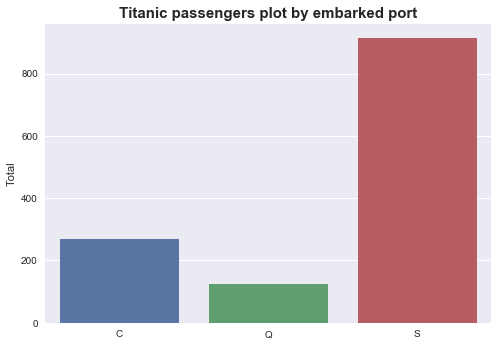

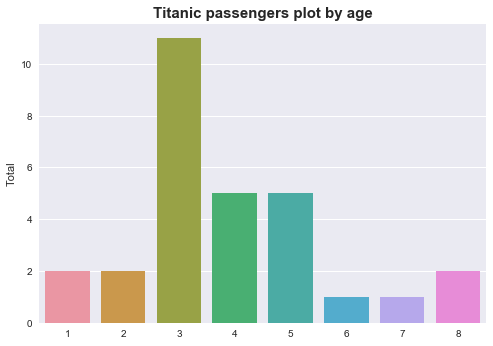

In [29]:
def titanic_plot(y, xlbl):
    fig, ax = plt.subplots()
    ax.set_title('Titanic passengers plot by '+ xlbl , fontsize=15, fontweight='bold')
    sns.barplot(y.keys(), y, ax=ax)
    locs, labels = plt.xticks()
    plt.ylabel('Total')
    plt.show()

    

titanic_plot(titanic.pclass.value_counts(),'pclass')
titanic_plot(titanic.sex.value_counts(),'sex')
titanic_plot(titanic.embarked.value_counts(),'embarked port')
titanic_plot(titanic.age.value_counts(),'age')



###############insert comment about missing data

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


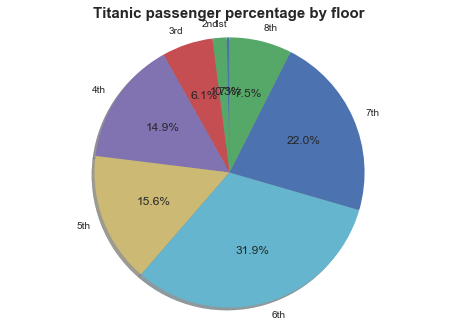

In [16]:
#every letter identify a floor, so I trasform each cabin attribute in this
#single letter, not considerng missing value(parameter na=False)

titanic_c = titanic.copy()
lista = ['A','B','C','D','E','F','G','T']
for letter in lista:
    titanic_c['cabin'][titanic_c['cabin'].str.contains(letter, na=False)] = letter

# memorize in titanic_c only the attribute cabin, deleting the missing values
titanic_c = titanic_c.cabin.dropna()

#count the total number of cabin known
cabins = len(titanic_c)
#calculate the percentage of passenger for each plan
cabins_count=titanic_c.value_counts() 
perc = cabins_count/cabins*100

#plot

labels = '1st', '2nd','3rd','4th','5th','6th','7th','8th'
sizes = [perc['T'],perc['G'], perc['F'], perc['E'], perc['D'], perc['C'], perc['B'], perc['A']]
fig1, ax1 = plt.subplots()
ax1.set_title('Titanic passenger percentage by floor ' , fontsize=15, fontweight='bold')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()


We expect that the more the class decreases, the more the number of survivors descreases. Our expectation is confirmed by the plots.


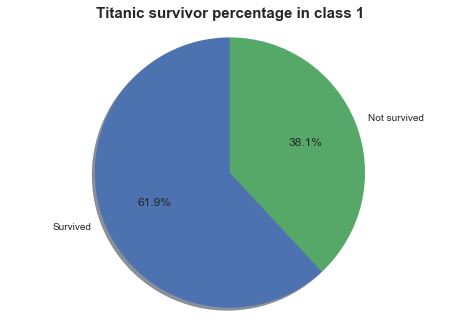

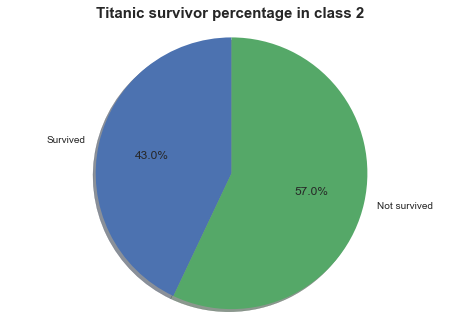

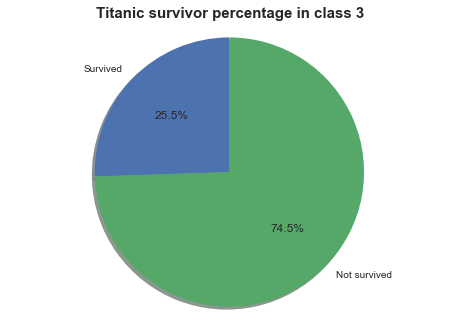

In [17]:
titanic['pclass'] = titanic.pclass.astype('float')
#function for plots
def titanic_pie_chart(s,ns):
    labels = 'Survived', 'Not survived'
    sizes = [s, ns]
    fig1, ax1 = plt.subplots()
    ax1.set_title('Titanic survivor percentage in class ' + repr(i) , 
                  fontsize=15, fontweight='bold')
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  
    plt.show()

#grouping data and calculate number of survivor per class
titanic_grouped = titanic.groupby(titanic.pclass)
x = titanic_grouped.aggregate(np.sum)
y = titanic.pclass.value_counts()  

#plots
for i in range(1,4):
    s=100*x.survived.loc[i]/y[i]
    ns=100-s
    titanic_pie_chart(s,ns)


We suppose that the most part of the survivors will be women and our supposition is confirmed by the data.

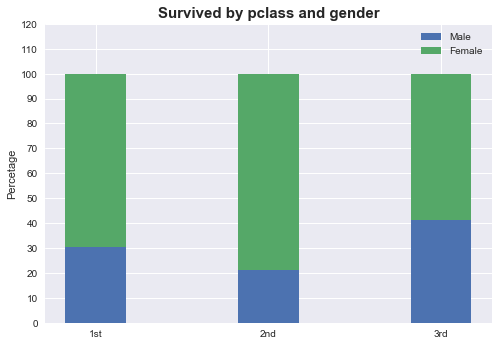

In [28]:
#group and aggregate data
titanic_grouped = titanic.groupby(['sex','pclass'])
x = titanic_grouped.aggregate(np.sum)

#calculate percentage 
ms = x.survived.loc['male']/(x.survived.loc['male']+x.survived.loc['female'])*100
ws = x.survived.loc['female']/(x.survived.loc['male']+x.survived.loc['female'])*100

#plot
ind = np.arange(3)   
width = 0.35       
p1 = plt.bar(ind, ms, width, )
p2 = plt.bar(ind, ws, width, bottom=ms)
plt.ylabel('Percetage')
plt.title('Survived by pclass and gender',fontsize=15, fontweight='bold')
plt.xticks(ind, ('1st', '2nd', '3rd'))
plt.yticks(np.arange(0, 130, 10))
plt.legend((p1[0], p2[0]), ('Male', 'Female'))
plt.show()


In [19]:
#####6th

sex_map = {'male': 0, 'female': 1}
titanic2['sex'] = titanic2.sex.map(sex_map)


In [20]:
titanic3=pd.DataFrame()
titanic3['age']=titanic2.age
titanic3['survived']=titanic2.survived
titanic3['pclass']=titanic2.pclass
titanic3['sex']=titanic2.sex
titanic3=titanic3.dropna()
titanic3['age'] = pd.qcut(titanic3.age, [0, 0.5, 1])


In [21]:
titanic3.dtypes
#embarked_map = {'S': 1, 'C': 2 , 'Q': 3}
#titanic3['age'] = titanic.age.map(age_map)
#titanic3.age



age         category
survived       int64
pclass         int64
sex            int64
dtype: object

In [22]:
titanic_grouped=titanic3.groupby(['sex','pclass','age'])

x=titanic_grouped.aggregate(np.sum)

In [23]:
y=titanic_grouped.size()
y[0,1]

age
(0.166, 28.0]     32
(28.0, 80.0]     119
dtype: int64

In [24]:
x.loc[0,1]

,survived
age,
"(0.166, 28.0]",17
"(28.0, 80.0]",36


In [25]:
y

sex  pclass  age          
0    1       (0.166, 28.0]     32
             (28.0, 80.0]     119
     2       (0.166, 28.0]     74
             (28.0, 80.0]      84
     3       (0.166, 28.0]    224
             (28.0, 80.0]     125
1    1       (0.166, 28.0]     41
             (28.0, 80.0]      92
     2       (0.166, 28.0]     56
             (28.0, 80.0]      47
     3       (0.166, 28.0]    109
             (28.0, 80.0]      43
dtype: int64

In [26]:
x

survived
sex pclass age                    
0   1      (0.166, 28.0]        17
           (28.0, 80.0]         36
    2      (0.166, 28.0]        16
           (28.0, 80.0]          7
    3      (0.166, 28.0]        41
           (28.0, 80.0]         18
1   1      (0.166, 28.0]        39
           (28.0, 80.0]         89
    2      (0.166, 28.0]        51
           (28.0, 80.0]         41
    3      (0.166, 28.0]        56
           (28.0, 80.0]         16

In [27]:
for i in range(0,2):
    for j in range(1,4):
        survived=

SyntaxError: invalid syntax (<ipython-input-27-249f24beaa6b>, line 3)